In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne

from Cho2017 import SubjectData


plt.rcParams['figure.figsize'] = [12, 8]

# # Make sure ipympl is installed (via pip) for interactive plots in Jupyter 
# %matplotlib widget

In [2]:
s01 = SubjectData('s01.mat')

Creating RawArray with float64 data, n_channels=69, n_times=358400
    Range : 0 ... 358399 =      0.000 ...   699.998 secs
Ready.
Creating RawArray with float64 data, n_channels=69, n_times=358400
    Range : 0 ... 358399 =      0.000 ...   699.998 secs
Ready.
Creating RawArray with float64 data, n_channels=69, n_times=71680
    Range : 0 ... 71679 =      0.000 ...   139.998 secs
Ready.
Creating RawArray with float64 data, n_channels=69, n_times=71680
    Range : 0 ... 71679 =      0.000 ...   139.998 secs
Ready.
Creating RawArray with float64 data, n_channels=68, n_times=34048
    Range : 0 ... 34047 =      0.000 ...    66.498 secs
Ready.
Creating RawArray with float64 data, n_channels=68, n_times=5120
    Range : 0 ... 5119 =      0.000 ...     9.998 secs
Ready.
Creating RawArray with float64 data, n_channels=68, n_times=5120
    Range : 0 ... 5119 =      0.000 ...     9.998 secs
Ready.
Creating RawArray with float64 data, n_channels=68, n_times=5120
    Range : 0 ... 5119 =      0.

In [3]:
tmin = -1
tmax = 4
reject_criteria = {'eeg': 350e-6}       # 150 µV The default from the overview tutorial
filter_freqs = (7, 30)
filter_props = dict(picks=['eeg'], fir_design='firwin', skip_by_annotation='edge')

imagery_events = mne.find_events(s01.raw_imagery_left, stim_channel=s01.stim_channel)   # Same stim for imagery l/r
im_left_epochs = mne.Epochs(s01.raw_imagery_left, imagery_events, tmin=tmin, tmax=tmax,
                            preload=True, reject=reject_criteria).filter(*filter_freqs, **filter_props)
im_right_epochs = mne.Epochs(s01.raw_imagery_right, imagery_events, tmin=tmin, tmax=tmax,
                             preload=True, reject=reject_criteria).filter(*filter_freqs, **filter_props)

movement_events = mne.find_events(s01.raw_movement_left, stim_channel=s01.stim_channel)  # Same stim for movement l/r
movement_left_epochs = mne.Epochs(s01.raw_movement_left, movement_events, tmin=tmin, tmax=tmax,
                                  preload=True, reject=reject_criteria).filter(*filter_freqs, **filter_props)
movement_right_epochs = mne.Epochs(s01.raw_movement_right, movement_events, tmin=tmin, tmax=tmax,
                                  preload=True, reject=reject_criteria).filter(*filter_freqs, **filter_props)

100 events found
Event IDs: [1]
Not setting metadata
Not setting metadata
100 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 100 events and 2561 original time points ...
    Rejecting  epoch based on EEG : ['FP1', 'FPZ']
    Rejecting  epoch based on EEG : ['FP1', 'AF7', 'AF3', 'FPZ', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'AF7', 'FPZ', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'AF7', 'FPZ', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'FPZ', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'FPZ', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'FPZ', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'FPZ', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'AF7', 'FPZ', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'AF7', 'AF3', 'FPZ', 'FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP1', 'AF7',

In [4]:
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

from mne.decoding import CSP

In [5]:
#im_left_epochs = im_left_epochs#.copy().crop(tmin=1., tmax=2.)   # Not sure why the guy cropped this
im_left_data = im_left_epochs.copy().pick_types(eeg=True)
im_right_data = im_right_epochs.copy().pick_types(eeg=True)
im_left_labels = im_left_epochs.events[:, -1] - 1   # Label: 0
im_right_labels = im_right_epochs.events[:, -1]     # Label: 1

im_data = np.vstack((im_left_data.get_data(), im_right_data.get_data()))
im_labels = np.hstack((im_left_labels, im_right_labels))


print('Left Imagery Data Shape:', im_left_data.get_data().shape,
      '\t\tRight:', im_right_data.get_data().shape)
print('Left Lables:', np.unique(im_left_labels), 'Shape:', im_left_labels.shape,
     '\t\t\t\tRight:', np.unique(im_right_labels), 'Shape:', im_right_labels.shape)
print('Imagery Dataset Shape:', im_data.shape)
print('Imagery Labels Shape:', im_labels.shape)

scores = []
# epochs_data = im_left_epochs.get_data()     # Not sure what this is for yet
#epochs_data_train = epochs_train.get_data()  # What is this for?
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(im_data)

Left Imagery Data Shape: (58, 64, 2561) 		Right: (49, 64, 2561)
Left Lables: [0] Shape: (58,) 				Right: [1] Shape: (49,)
Imagery Dataset Shape: (107, 64, 2561)
Imagery Labels Shape: (107,)


In [6]:
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, im_data, im_labels, cv=cv, n_jobs=8)

In [7]:
class_balance = np.mean(im_labels == im_labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

Classification accuracy: 0.736364 / Chance level: 0.542056


Computing rank from data with rank=None
    Using tolerance 0.00026 (2.2e-16 eps * 64 dim * 1.8e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00022 (2.2e-16 eps * 64 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


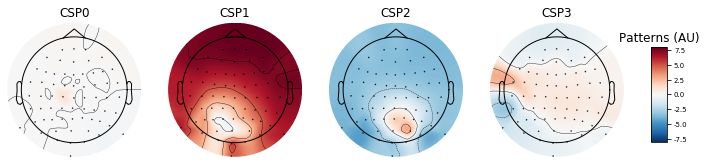

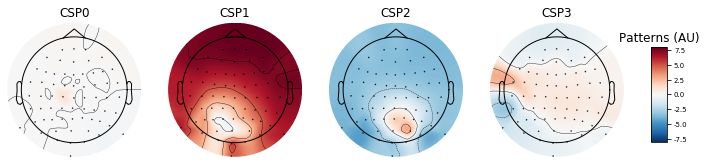

In [8]:
_ = csp.fit_transform(im_data, im_labels)

csp.plot_patterns(im_left_epochs.copy().pick_types(eeg=True).info, ch_type='eeg',
                 units='Patterns (AU)', size=1.5)
csp.plot_patterns(im_right_epochs.copy().pick_types(eeg=True).info, ch_type='eeg',
                 units='Patterns (AU)', size=1.5);